In [ ]:
# устанавливаем необходимые зависимости

!pip3 install transformers==4.22.1
!pip3 install torch==1.7.0+cu92
!pip3 install opencv-python==4.5.4
!pip3 install segments-ai
!pip3 install imutils==0.5.4
!pip3 install pathlib
!pip3 install Pillow==7.0.0
!pip3 install numpy==1.21.6
!pip3 install pandas==0.25.3
!pip3 install matplotlib==3.1.2

In [25]:
import os
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt

import cv2
from cv2 import VideoWriter_fourcc
import imutils
from imutils.video import VideoStream, FPS
from IPython.display import clear_output
from IPython.display import Video
from PIL import Image,ImageDraw

# без этого падает обучение обязательно до импорта torch
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


import torch
from torch import nn

from segments.utils import get_semantic_bitmap

import transformers
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

In [20]:
!pip3 install session-info

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8046 sha256=c2b8a1cae9e81b2c7f51c5905641cb55729df1642ecc8fceccea985a8d93173a
  Stored in directory: /tmp/pip-ephem-wheel-cache-51vgv3g6/wheels/bd/ad/14/6a42359351a18337a8683854cfbba99dd782271f2d1767f87f
Successfully built session-info


In [2]:
BASE_DIR = Path().cwd()

# поднимаем модель с диска
model_dir = BASE_DIR.joinpath('segformer-b0-finetuned-segments-license-plate', 'checkpoint-20300')
input_video_file = BASE_DIR.joinpath('data', 'VID_20190810_064327.mp4')
output_video_file = BASE_DIR.joinpath('data', 'output_VID_20190810_064327.avi')

In [3]:
# базовая модель
pretrained_model_name = "nvidia/mit-b0" 
# инициализируем модель и feture extractor
feature_extractor = SegformerFeatureExtractor.from_pretrained(pretrained_model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_dir)

In [4]:
num_labels = 5

id2label={0: 'unlabeled',
          1: 'license plate',
          2: 'car',
          3: 'truck',
          4: 'emergency'}
label2id={'unlabeled':0,
          'license plate':1,
          'car': 2,
          'truck': 3,}


# возвращаем разцветку классов
def plate_palette():
    """Plate palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [0,113,188],
        [236,176,31],
        [125,46,141],
        [118,171,47]
    ]

# наклкдываем сегментацию н аизображение и возвращаем все найденные классы
def get_seg_overlay(image, seg):
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(plate_palette())
    classes = {}
    for label, color in enumerate(palette):
        
        color_seg[seg == label, :] = color
    classids = np.unique(seg).tolist()
    
    classes = {k:id2label.get(k) for k in classids}
    
#     w, h = image.size[0], image.size[1]
#     img1 = ImageDraw.Draw(image)
#     shape = [(40, 40), (w - 10, h - 10)]
#     img1.rectangle(shape, fill =None, outline ="red")
    
    # отрисовываем маску
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)


    return img, classes


def get_seg_image(image):
    """
    Отрисовываем сегментацию на изображении
    """
    
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits

    # преобразуем логитсы к размеру изображения
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1], # (height, width)
        mode='bilinear',
        align_corners=False
    )

    # выбираем сработавший класс
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    
    pred_img, color_seg = get_seg_overlay(image, pred_seg)
    return pred_img, color_seg

In [8]:
# Захват видеопотока
video_stream = cv2.VideoCapture(str(input_video_file))

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
frame_width = int(video_stream.get(3))
frame_height = int(video_stream.get(4))

# Будем выводить обработанное видео с отрисованными номером в отдельный файл 
out = cv2.VideoWriter(str(output_video_file), fourcc , 25, (frame_width, frame_height))

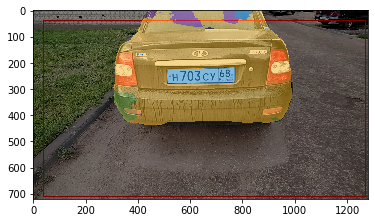

In [9]:
# Обрабтываем каждый кадр захваченного видеопотока
while True:
    (grabbed, frame) = video_stream.read()
    if not grabbed:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = Image.fromarray(frame)
    pred_img, color_seg = get_seg_image(image=frame)
    im_np = np.asarray(pred_img)
    im_np = cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR)
    out.write(im_np)